### Now that I have full imaging code, it's time to clean it up and start documenting things

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  For CPU use 16K appears best.
blocklenk = 16
blocklen = (blocklenk * 1024)

# hilbert_filter_terms has a direct impact on filter delays
hilbert_filter_terms = 1024
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
blockcut = hilbert_filter_terms + 192

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def doplot(B, A, freq = 40):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return db

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Load up default parameters

params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
hz0ire = params['videorf_0ire']

In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, count=10):
    start_offset = int(_start_offset)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

#doplot(tf_b, tf_a)

In [11]:
# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = 256
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]))
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [12]:
# The actual video demodulation code

def dodemod(paramsc, data, usemtf = False, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [13]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9450000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [14]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [15]:
def demod(infile, _start, _end, filterset, usemtf = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen )
            break
    
        tmp = dodemod(filterset, indata, usemtf=usemtf)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    return output

In [16]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [17]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [18]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(blocklen, dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [19]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    print(startsync)
    
    try:
        scanstart = (startsync - (ilinepx * 8))
        lastlinepresync = scanstart + np.where(syncf[scanstart: startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line", startsync)
        lastlinepresync = None
        presync_eqlen = None

    try:
        #print(endsync)
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line", endsync)
        nextline = None
        postsync_eqlen = None

    #print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

#findburstfromsync(rdata['demod_sync'], 190301)

In [20]:
def findsync(output_sync, loc = 0):
    loc = 0

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

    if np.max(output_sync[loc:loc+imglen]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    #print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap >= 3.75:
        firstfield = False
    else:
        firstfield = True
    
    return syncloc, firstfield, nextline

In [21]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and not firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and firstfield:
            return loc + nextline, data
    
    return None

In [22]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [23]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], outwidth)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / outwidth)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

In [24]:
def phasecorrect(sdata, lineinfo, mult = 0.25, outfsc = 8):
    # NTSC only!
    outwidth = int(227.5 * outfsc)
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * outwidth: (l + 1) * outwidth][int(outfsc*1.25):int(outfsc*15)]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [25]:
def calcerr(subset):
    black = np.mean(subset)
    
    subseta = np.abs(subset - black)
    
    peaks = np.where(subseta > 80000)[0]
    toffset = 0
    noffsets = 0

    for p in range(0, len(peaks) - 1):
        if np.abs(subseta[peaks[p]] - subseta[peaks[p + 1]]) < 40000:
            zp = calczc(subset, peaks[p], black)

            if zp is not None:
                #print(peaks[p], subset[peaks[p]] - 8100000, zp, (zp - peaks[p] - 0))

                offset = (zp - peaks[p] - 1)
                toffset += offset
                noffsets += 1
            else:
                offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [380]:
# oddzc:  use odd # pixels for color burst zero crossings
def buildfield(frame, start = 0, oddzc = 0, phaseshift = 0, outfsc = 4):
    outwidth = int(227.5 * outfsc)
    
    output = frame['demod']
    output_sync = frame['demod_sync']
    output_lp = frame['demod_05']
    output_burst = frame['demod_burst']

    ilinepx = int(filterset['line_px'])
    
    syncloc1, firstfield, line1 = findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

    curloc = line1 + start

    lineinfo = [curloc]
    for i in range(0, 253):
        prevloc = curloc

        curloc += int(filterset['line_px'] * .9)
        offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
        curloc += offset 

        # if the sync detection burst doesn't look good, reuse the last one
        is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
        validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
        if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
            if i < 252:
                print("bad sync", i, curloc)
            curloc = prevloc + (lineinfo[-1] - lineinfo[-2])

    #    print(curloc, output[curloc], output[curloc+8])

        lineinfo.append(curloc)

    crossire = iretohz(-15)

    lineinfo2 = []

    for l in lineinfo:
        zc = calczc(output_lp, l - 5, crossire, 40) 

        if zc is None:
            lineinfo2.append(l)
            continue

        lineinfo2.append(zc - filterset['dgap_05'])
        #print(l, zc, output[l], output[l + 1], output[l + 2])

    lineinfo2[0] = lineinfo2[1] - (lineinfo2[2] - lineinfo2[1])
    
    # now for fine sync

    # first pass: check hsyncs and color burst quality.  Any spikes in either will cause
    # the line to be ignored and location interpolated.

    lineinfo_tmp = lineinfo2.copy()
    lineinfo3 = [(lineinfo2[0], lineinfo[1])]
    badburst = np.zeros_like(lineinfo_tmp)
    finalsnr = []

    for l in range(1, len(lineinfo2) - 1):
        # hsync check
        scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], outwidth) 
        subset = scaled[int(outwidth - (outfsc * 12)):outwidth]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1

        # color burst check
        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
        scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], outwidth) 
        subset = scaled[int(outfsc*1.5):int(outfsc*12.5)]

        #print(l, np.min(subset), np.max(subset))
        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1

    # and finer sync
    lineinfo_tmpa = lineinfo2.copy()
    offset = 0

    lineinfo_tmpa[0] = lineinfo_tmpa[1] - (lineinfo_tmpa[2] - lineinfo_tmpa[1])

    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(4))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(cut), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
            
        target = (np.round((adjpeak - oddzc) / 2) * 2) + oddzc

        #offset = (adjpeak - np.floor(adjpeak)) * (linelen / 910)
        prevoffset = offset
        offsets[l] = (adjpeak - target)

        #print(l, np.argmax(cut), np.max(cut), calczc(cut, np.argmax(cut), 0), adjpeak, target, offsets[l])

    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, len(lineinfo_tmpa) - 2):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 1])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2

    #shift33 = (33.0 / 360.0) * 4 * 2
    shift33 = 0

    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, len(lineinfo_tmpa) - 1):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    
        
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstphase = []
    field_cburst, sfactor = downscale_field(output_burst[128:], lineinfo_tmpa, outwidth)
    for i in range(0, len(lineinfo_tmpa)):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 2.5) + oddzc))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstphase.append((fcb29 > 0, np.fabs(fcb29 - fcb_mean) / hz_ire_scale))

    field, sfactor = downscale_field(output, lineinfo_cphaseadj, outwidth)

    return field, lineinfo_tmpa, burstphase


In [381]:
def pxtousec(px):
    return (px / filterset['freq_hz']) * 1000000

def usectopx(usec):
    return filterset['freq_hz'] * usec / 1000000

In [382]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

In [584]:
if True: # DD 3.0
    params['freq'] = 40.0
    deemp_adj1 = .345
    deemp_adj2 = .3325

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['audio_rfreq'] = 2880000

    params['vbpf'] = (3500000, 14000000)
    params['vbpf_order'] = 2

    params['vlpf_freq'] = 4500000
    params['vlpf_order'] = 6
    
else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

In [585]:
#infile = open('/home/cpage/ldcaps3/ggv_22000.raw', 'rb')
infile = open('/home/cpage/ldcaps3/ve_zone.raw', 'rb')
needmtf = False

In [586]:
outfsc = 4
outwidth = int(outfsc * 227.5)
oddzc=0

d, rdata = findfirstframe(infile, 1024*1024*0)

start = d - int(50 * filterset['line_px'])
data = demod(infile, start, d + int(600 * filterset['line_px']), filterset, needmtf)

fs = findsync(data['demod_sync'], 0)

start = 0
ilinepx = int(filterset['line_px'])

syncloc1, firstfield, line1 = findsync(data['demod_sync'][start:], 0)

frame = demod(infile, d - int(20 * filterset['line_px']), d + int(800 * filterset['line_px']), filterset, needmtf)
syncloc1, firstfield, line1 = findsync(frame['demod_sync'][0:int(24 * filterset['line_px'])], 0)

syncloc2, secondfield, line2 = findsync(frame['demod_sync'][int(250 * filterset['line_px']):int(290 * filterset['line_px'])], 0)
syncloc2 += int((250 - 0) * filterset['line_px']) 
line2 += int(250 * filterset['line_px'])

phaseshift = (33.0 / 360.0) * 4 * 2
lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, 0, oddzc=oddzc, outfsc=outfsc)

start = syncloc2 - int(15 * filterset['line_px'])
findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start, oddzc=oddzc, outfsc=outfsc)

combined = np.zeros((outwidth * 506), dtype=np.double)
for i in range(0, 505, 2):
    combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
    combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]


0 325120 325120
303584 629920 326336
542177 868513 326336
543393 0.999828426567 0.0882056919582
33232
543393 584033 False 0.999828426567 0.0882056919582
1151777 1478113 326336
1152993 0.999826703964 0.0879763919081
90914
1152993 1247500 True 0.999826703964 0.0879763919081
1132309 2784525 1652216
777773
777773
1208509 3292525 2084016
34182
66573
34182
outlier repair  235 [-0.60163633  0.92589013]
30693
30693
outlier repair  238 [-0.61171628  0.97177389]


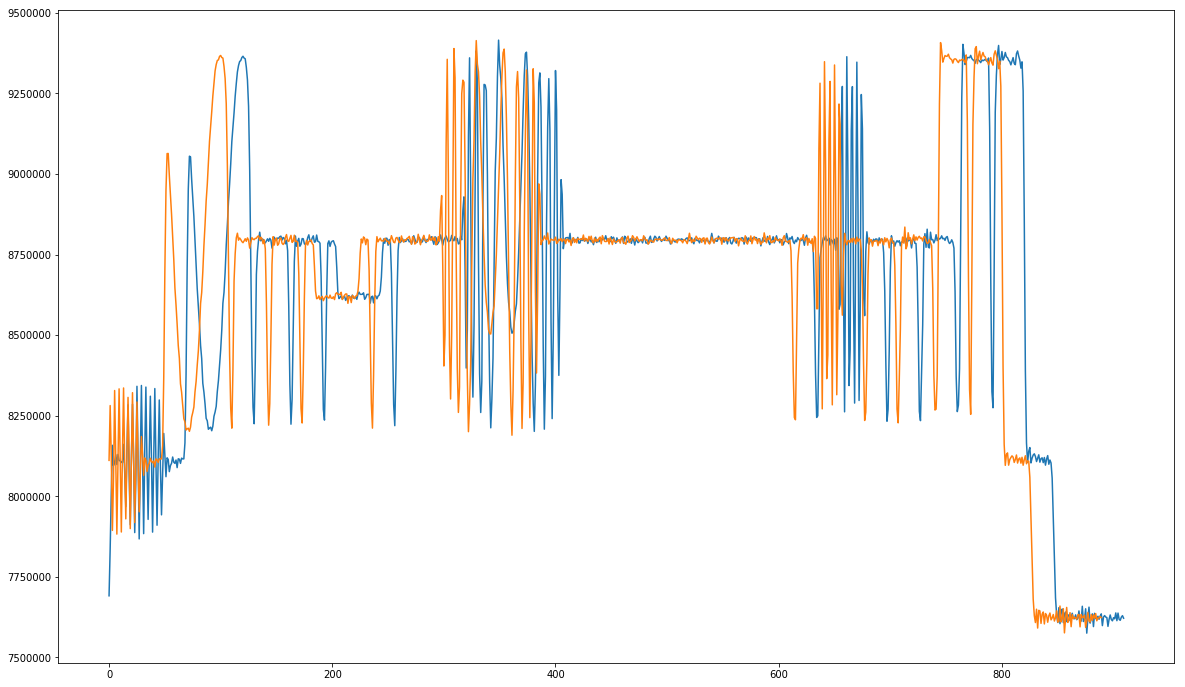

In [587]:
# 4x fsc 
l = 250
cut2 = combined[(l * outwidth) + 0:((l + 1) * outwidth)]
#cut1 = cut2
plt.plot(cut1)
plt.plot(cut2[20:])
#plt.plot(cut2[20:])

In [567]:
calcsnr(cut1[150:325]), calcsnr(cut2[150:325])

(15.58853753898358, 15.954678620734333)

(460460,)
uint8 (506, 910) (506, 910)


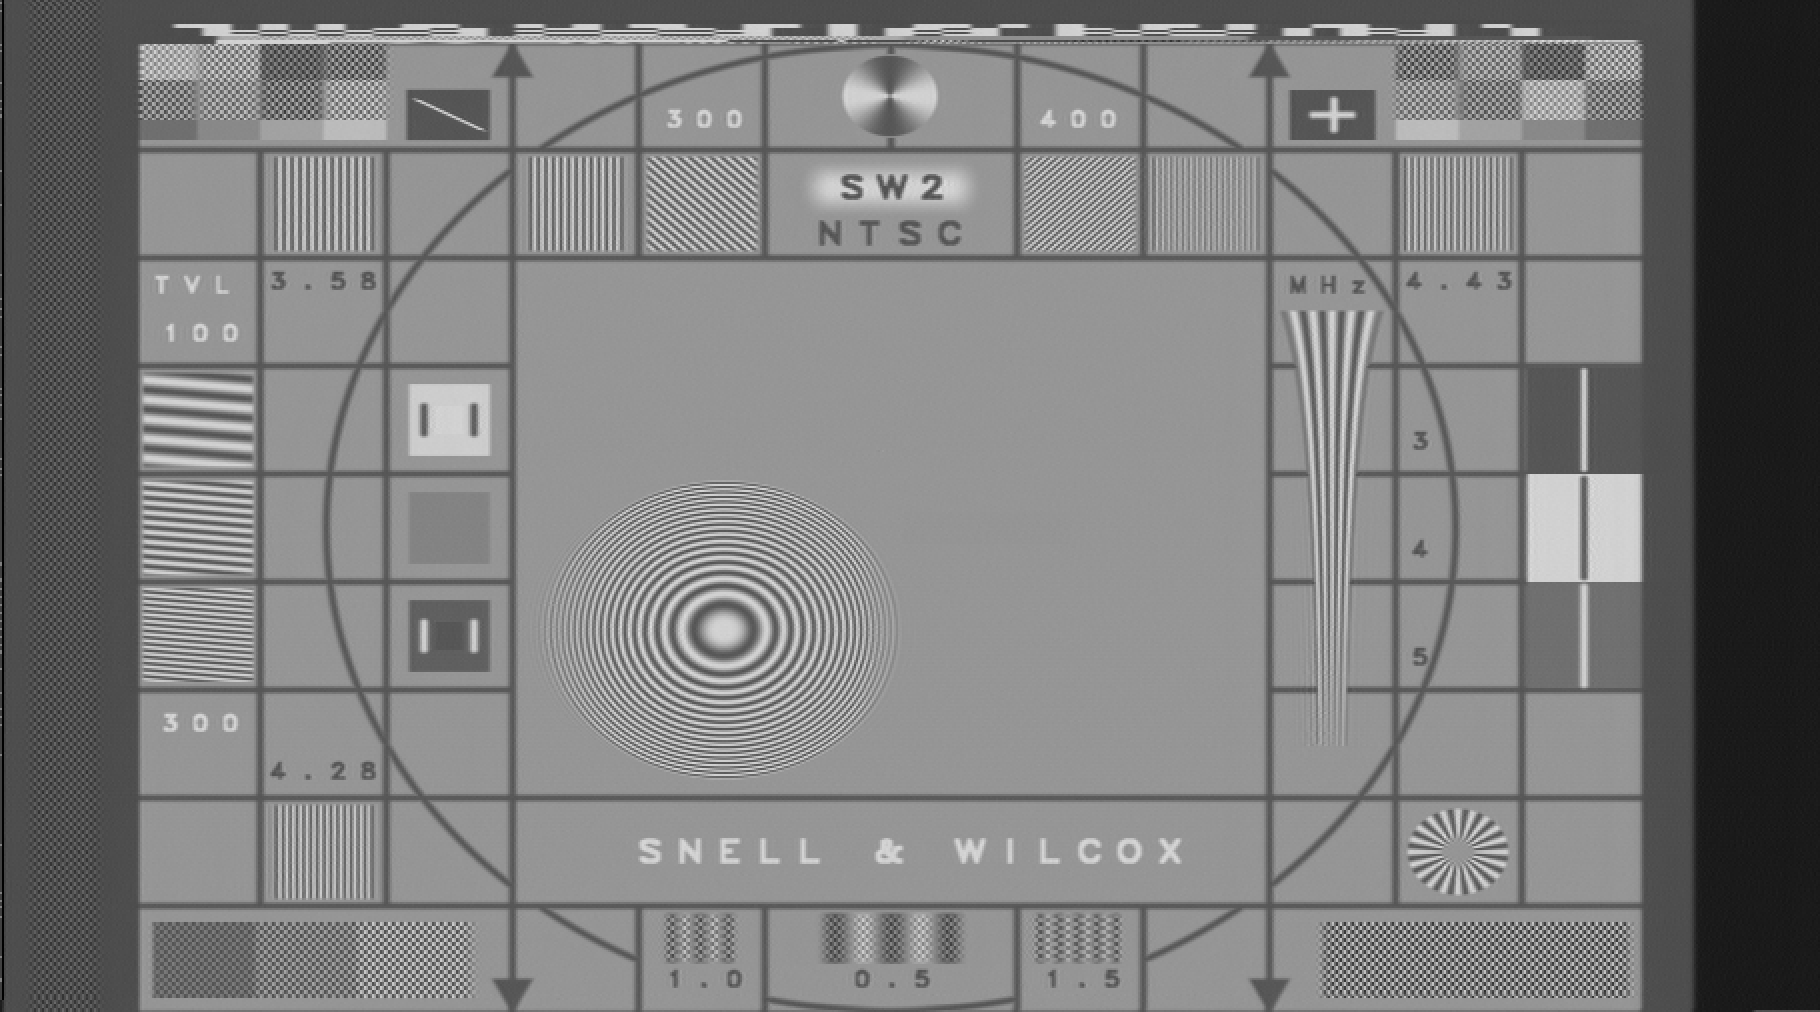

In [568]:
reduced = (combined - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

for i in range(0, 500, 2):
    if not lines_even_cburst[i // 2][0]:
        lines16[((i + 0) * outwidth)] = 32768
    else:
        lines16[((i + 0) * outwidth)] = 16384
        
    lines16[((i + 0) * outwidth) + 1] = np.uint16(327.67 * .8 * lines_even_cburst[i // 2][1])
    
    if not lines_odd_cburst[i // 2][0]:
        lines16[((i + 1) * outwidth)] = 32768
    else:
        lines16[((i + 1) * outwidth)] = 16384
        
    lines16[((i + 1) * outwidth) + 1] = np.uint16(327.67 * .8 * lines_odd_cburst[i // 2][1])

drawdata(lines16, outwidth, 506, hscale=2, vscale=2)

In [135]:
i

504

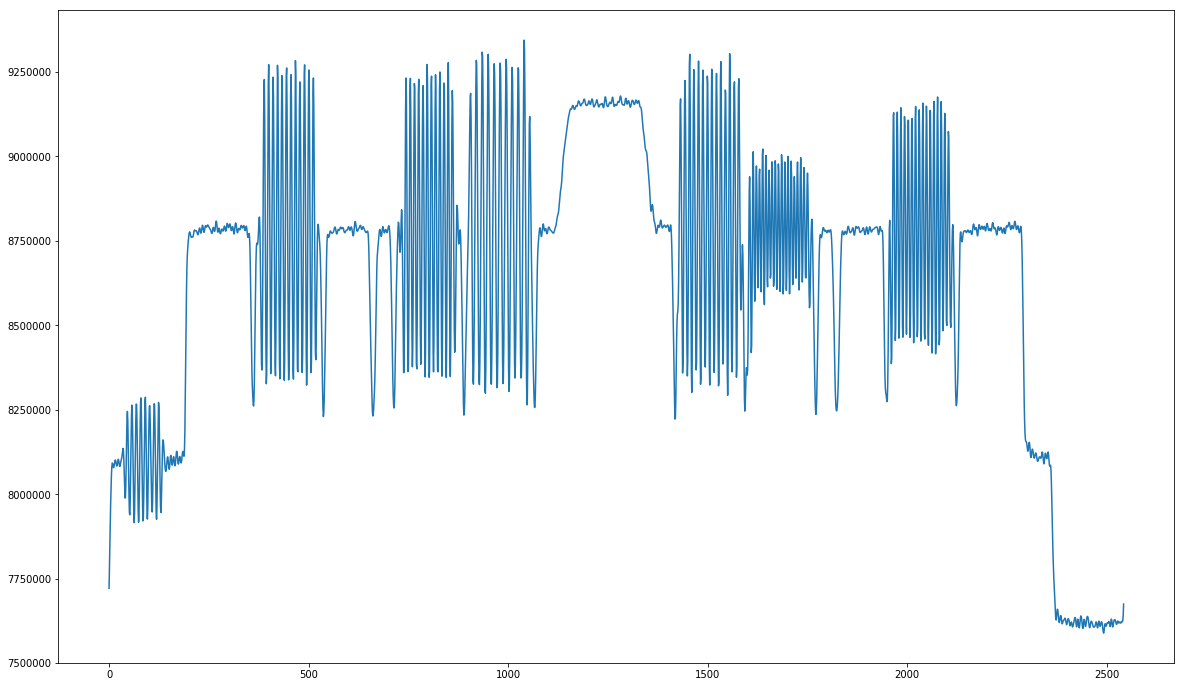

In [41]:
plt.plot(frame['demod'][int(lineinfo_even[50]):int(lineinfo_even[51])])

In [137]:
hztoire(8100000-4000)

-0.32941176470588235

In [42]:
# 8x fsc
l = 100
cut2 = combined[(l * outwidth) + 0:((l + 1) * outwidth)]
#cut1 = cut2
plt.plot(cut1[730:900])
plt.plot(cut2[730+2:900+2])

NameError: name 'cut1' is not defined

In [143]:
calcsnr(cut1[900:950])
calcsnr(cut2[900:950])

44.105421722918251

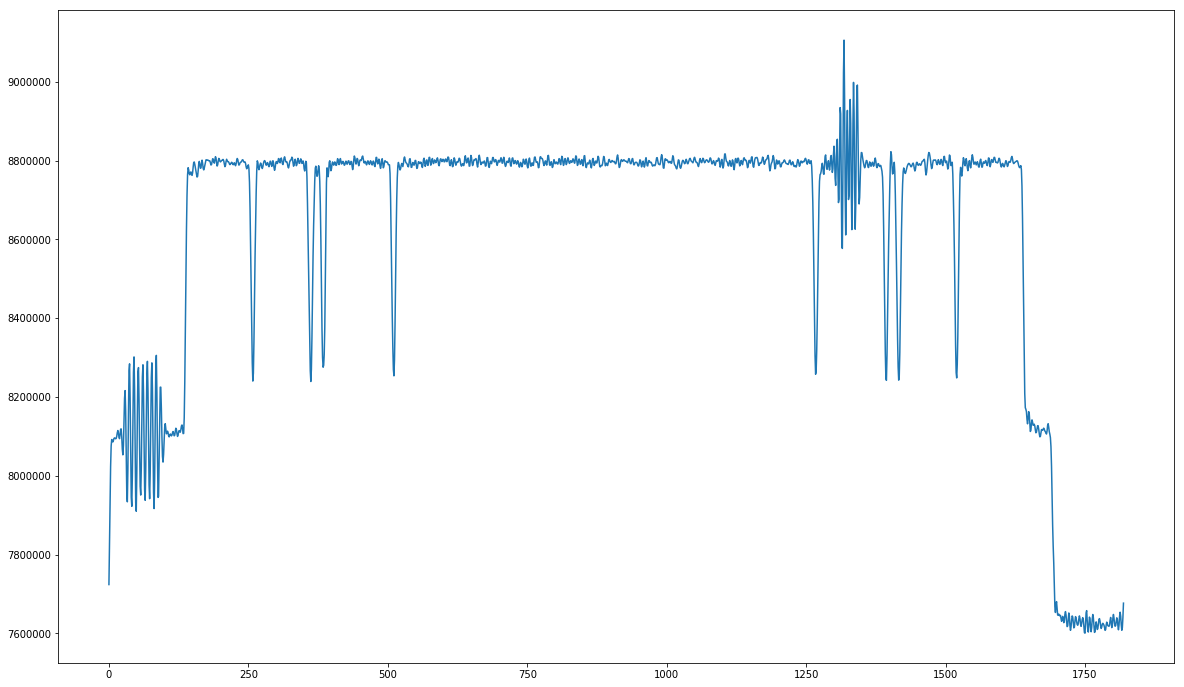

In [44]:
# 4x fsc 
l = 350
cut2 = combined[(l * outwidth) + 0:((l + 1) * outwidth)]
cut1 = cut2
plt.plot(cut1)

(40.287664393644896, 40.287664393644896)

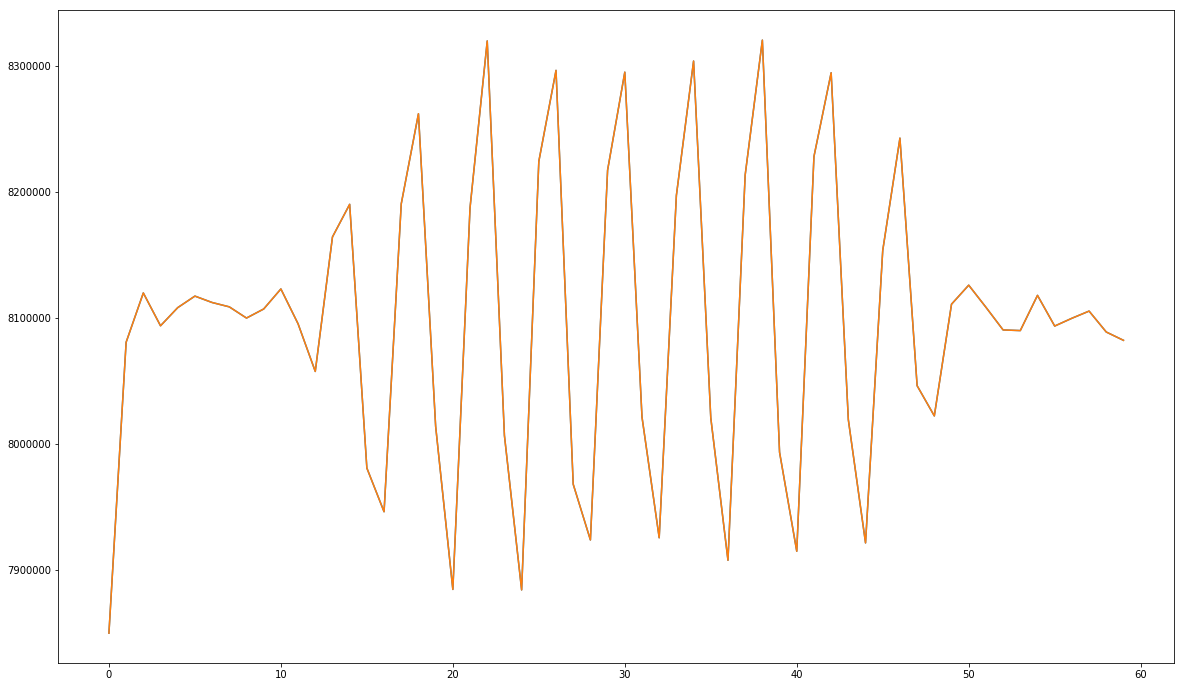

In [65]:
l = 20
cut2 = combined[(l * 910) + 0:((l + 1) * 910)]
#cut1 = cut2
plt.plot(cut1[0:60])
plt.plot(cut2[0:60])
calcsnr(cut1[120:350]), calcsnr(cut2[120:350])
#ca

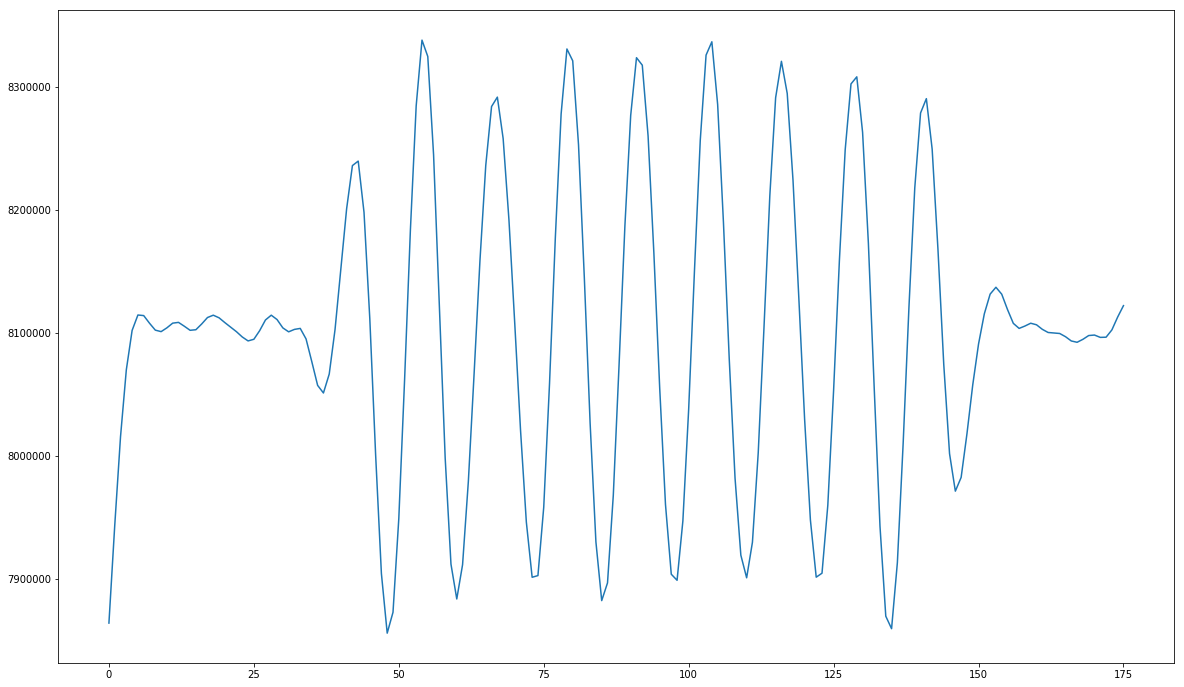

In [76]:
plt.plot(frame[int(lineinfo_even[200]):int(lineinfo_even[200]+usectopx(4))])

In [70]:
usectopx(4)

176.0

In [313]:
cut = combined[(l * 910) + 0:((l + 0) * 910) + 350].copy()

In [ ]:
frameout = np.zeros((844 * 505), dtype=np.uint16)

offset = -8

for i in range(1, 505):
    frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
    frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]

outfile = open('tmp.tbc', 'wb')
outfile.write(frameout)

In [221]:
i = 469

line1 = frameout[(i + 0) * 844: (i + 1) * 844]
line2 = frameout[(i + 1) * 844: (i + 2) * 844]

In [222]:
#plt.plot(line1[670:820])

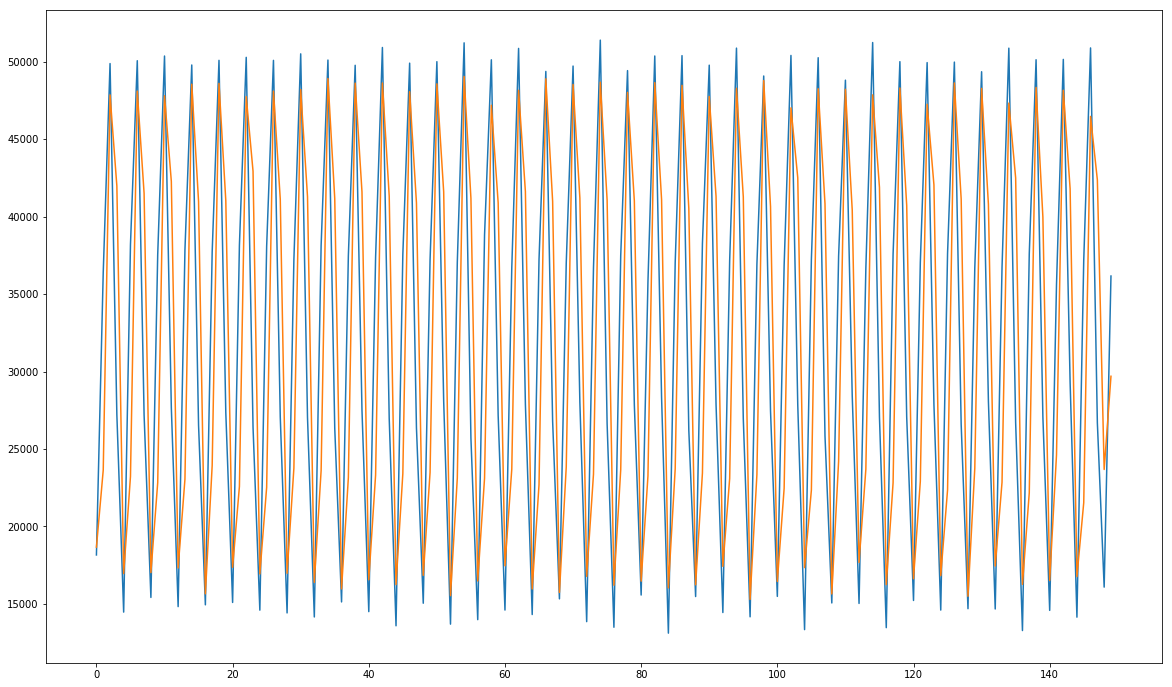

In [223]:
plt.plot(np.double(line1[670:820]))
plt.plot(np.double(line2[670:820]))

In [176]:
cut = (np.double(line1[670:800]) + np.double(line2[670:800]))

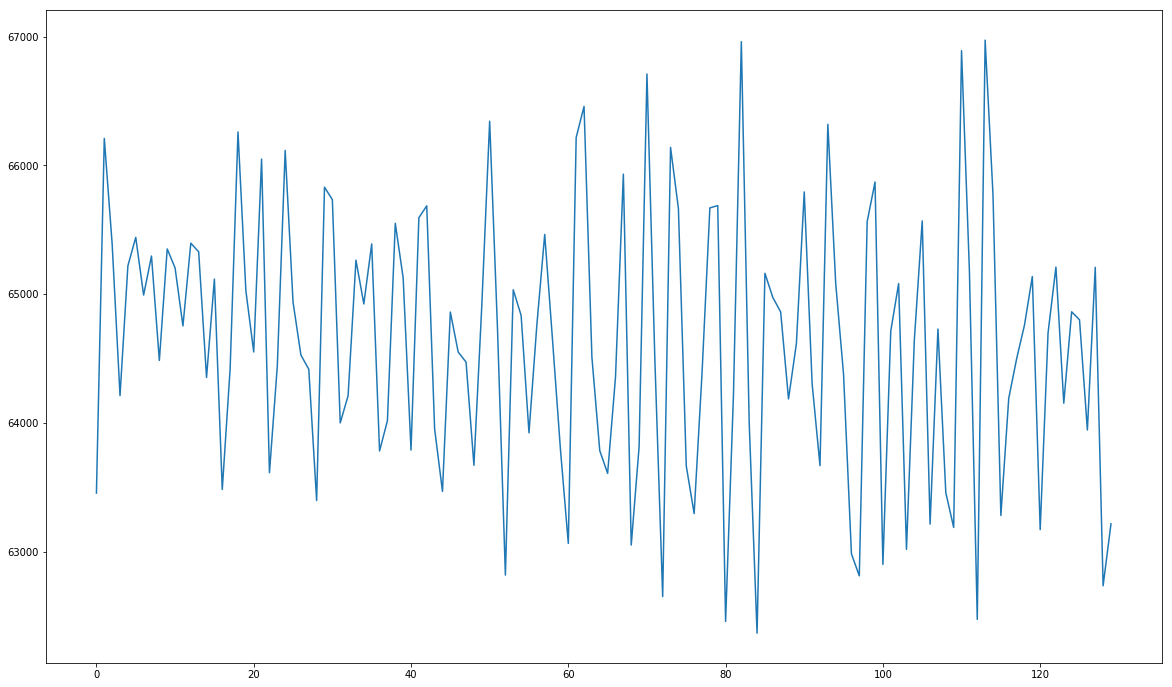

In [177]:
plt.plot(cut)

In [178]:
np.argmax(np.fft.fft(cut)[1:len(cut)//2])

20

In [179]:
(4*315/88)*(20/(len(cut)/2))

4.405594405594406

In [180]:
np.mean(cut), np.std(cut), np.std(line1[670:820])

(64630.630769230767, 1047.3896647487434, 13078.73922613678)

In [182]:
#stdi = np.std(a) / NTSC_hz_ire
(20 * np.log10(np.std(line1[670:800]) / np.std((np.double(line1[670:800]) + np.double(line2[670:800])))))

21.947050651893505

In [46]:
# tbc effectiveness check - line length.  lineinfo3 is pretty even
#plt.plot(np.diff(lineinfo2[1:220])))
#plt.plot(np.diff(lineinfo_tmpa[1:220]))

NameError: name 'lineinfo_tmpa' is not defined

In [62]:
1.1*1.7

1.87

In [220]:
1.87+7.6

9.469999999999999

In [221]:
12.2-9.5

2.6999999999999993